# 配置虚拟环境+导入相关库

创建了一个虚拟环境，这样某些相关库不会报错
相关配置见 requirement.txt

In [1]:
import sys
print(sys.executable)

e:\study\CASAterm2\CASA0003\groupwork\coffeestory\.venv\Scripts\python.exe


In [4]:
import osmnx as ox
import geopandas as gpd

In [5]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [17]:
import json

In [19]:
import os

In [24]:
import requests
import time

# get poi

## osm获取

In [3]:
# 定义城市列表
cities = {
    "Tokyo": "Tokyo, Japan",
    "Melbourne": "Melbourne, Australia",
    "Rome": "Rome, Italy",
    "Guangzhou": "Guangzhou, China"
}

In [4]:
for city_name, city_query in cities.items():
    print(f"Fetching cafes in {city_name}...")
    
    cafes = ox.geometries_from_place(city_query, tags={"amenity": "cafe"})
    cafes = cafes[["name", "geometry", "amenity"]].copy()
    cafes["city"] = city_name

    cafes.to_file(f"{city_name.lower()}_cafes.geojson", driver="GeoJSON")

print("All city POI saved!")

Fetching cafes in Tokyo...


C:\Users\10851\AppData\Local\Temp\ipykernel_27476\30475318.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  cafes = ox.geometries_from_place(city_query, tags={"amenity": "cafe"})


Fetching cafes in Melbourne...


C:\Users\10851\AppData\Local\Temp\ipykernel_27476\30475318.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  cafes = ox.geometries_from_place(city_query, tags={"amenity": "cafe"})


Fetching cafes in Rome...


C:\Users\10851\AppData\Local\Temp\ipykernel_27476\30475318.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  cafes = ox.geometries_from_place(city_query, tags={"amenity": "cafe"})


Fetching cafes in Guangzhou...


C:\Users\10851\AppData\Local\Temp\ipykernel_27476\30475318.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  cafes = ox.geometries_from_place(city_query, tags={"amenity": "cafe"})


All city POI saved!


In [9]:
# 文件路径字典
files = {
    "Tokyo": "tokyo_cafes.geojson",
    "Melbourne": "melbourne_cafes.geojson",
    "Rome": "rome_cafes.geojson",
    "Guangzhou": "guangzhou_cafes.geojson"
}

# 初始化结果容器
geometry_summary = {}

# 遍历每个城市并统计几何类型
for city, filepath in files.items():
    gdf = gpd.read_file(filepath)
    geom_counts = gdf.geometry.geom_type.value_counts()
    geometry_summary[city] = geom_counts

# 整理成 DataFrame 展示
summary_df = pd.DataFrame(geometry_summary).fillna(0).astype(int)
print(summary_df)

         Tokyo  Melbourne  Rome  Guangzhou
Point     4557       2521  1989        342
Polygon    144        432   124          9


In [11]:
# 分离 point 和 polygon
points = gdf[gdf.geometry.geom_type == "Point"]
polygons = gdf[gdf.geometry.geom_type == "Polygon"]

points = points.to_crs(epsg=4326)
polygons = polygons.to_crs(epsg=4326)

# 找出所有点在某个多边形内的情况
joined = gpd.sjoin(points, polygons, how="inner", predicate="within")

# 输出可能重复或重合的项
print(joined[["name_left", "name_right"]])


Empty DataFrame
Columns: [name_left, name_right]
Index: []


In [12]:
# 筛选 Polygon 类型数据
polygons = gdf[gdf.geometry.geom_type == "Polygon"]

# 查看其属性列（不包含 geometry）和前几行内容
print(polygons.head())


    element_type       osmid    name amenity       city  \
6            way  1237736430     咖啡厅    cafe  Guangzhou   
138          way  1144924594  家·湾区书屋    cafe  Guangzhou   
139          way  1380577122      茶饮    cafe  Guangzhou   
140          way  1380581973   王者奶茶店    cafe  Guangzhou   
145          way   180524998    今啡昔笔    cafe  Guangzhou   

                                              geometry  
6    POLYGON ((113.64734 22.62422, 113.64750 22.624...  
138  POLYGON ((113.33586 23.12288, 113.33586 23.122...  
139  POLYGON ((113.40090 22.95314, 113.40118 22.953...  
140  POLYGON ((113.40482 22.95163, 113.40507 22.951...  
145  POLYGON ((113.48945 23.45412, 113.48959 23.453...  


In [13]:
for city, path in files.items():
    print(f"正在处理：{city}")

    # 读取数据
    gdf = gpd.read_file(path)

    # 分离点与面
    points = gdf[gdf.geometry.geom_type == "Point"]
    polygons = gdf[gdf.geometry.geom_type == "Polygon"].copy()

    # 将面转为质心
    polygons["geometry"] = polygons.centroid

    # 合并为统一 Point 数据集
    unified = pd.concat([points, polygons], ignore_index=True)
    unified = unified.set_geometry("geometry")  # 确保几何列正确
    unified = unified.to_crs(epsg=4326)         # 保持统一坐标系

    # 覆盖保存（可加 backup 步骤）
    unified.to_file(path, driver="GeoJSON")

    print(f"✅ {city} 处理完成，共 {len(unified)} 条记录\n")

正在处理：Tokyo


C:\Users\10851\AppData\Local\Temp\ipykernel_25216\1065328155.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons["geometry"] = polygons.centroid


✅ Tokyo 处理完成，共 4701 条记录

正在处理：Melbourne


C:\Users\10851\AppData\Local\Temp\ipykernel_25216\1065328155.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons["geometry"] = polygons.centroid


✅ Melbourne 处理完成，共 2953 条记录

正在处理：Rome


C:\Users\10851\AppData\Local\Temp\ipykernel_25216\1065328155.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons["geometry"] = polygons.centroid


✅ Rome 处理完成，共 2113 条记录

正在处理：Guangzhou
✅ Guangzhou 处理完成，共 351 条记录



C:\Users\10851\AppData\Local\Temp\ipykernel_25216\1065328155.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons["geometry"] = polygons.centroid


In [28]:
# 高德 API KEY
API_KEY = "bdf74acc1a05a303c5162d2d86f2c829"

# 广州各行政区（可按你实际 geojson 中使用的命名修改）
districts = [
    "天河区", "越秀区", "海珠区", "荔湾区", "白云区",
    "黄埔区", "番禺区", "花都区", "南沙区", "从化区", "增城区"
]

# 多关键词组合（可拓展）
keywords = [
    "咖啡", "coffee", "cafe", "咖啡馆", "咖啡厅", "咖啡店",
    "星巴克", "瑞幸", "luckin", "manner", "seesaw", "m stand",
    "arabica", "lavazza", "peet's", "tims", "黑狮", "三顿半",
    "fishtank", "唯寻", "bloom", "still", "modu"
]

# 每页最多返回 20 条
page_size = 20
max_pages = 50  # 每关键词-区 最多 1000 条

results = []

for district in districts:
    for keyword in keywords:
        print(f"\n📍 抓取 [{district}] 中关键词 [{keyword}] ...")
        for page in range(1, max_pages + 1):
            url = f"https://restapi.amap.com/v3/place/text?keywords={keyword}&city={district}&citylimit=true&output=json&offset={page_size}&page={page}&key={API_KEY}"
            r = requests.get(url)
            data = r.json()

            if data.get("status") != "1":
                print(f"❌ 请求失败：{data.get('info')}")
                break

            pois = data.get("pois", [])
            if not pois:
                break  # 没有更多数据了

            for poi in pois:
                results.append({
                    "name": poi.get("name"),
                    "type": poi.get("type"),
                    "address": poi.get("address"),
                    "location": poi.get("location"),
                    "tel": poi.get("tel"),
                    "province": poi.get("pname"),
                    "city": poi.get("cityname"),
                    "district": poi.get("adname"),
                    "keyword": keyword
                })

            print(f"✅ 第 {page} 页完成，累计 {len(results)} 条")
            time.sleep(0.3)  # 控制请求频率，防止被封

print(f"\n🎉 全部抓取完成，共 {len(results)} 条记录。")

# 保存为 DataFrame 并去重（按店名+位置）
df = pd.DataFrame(results)
df.drop_duplicates(subset=["name", "location"], inplace=True)
df.to_csv("guangzhou_cafes_gaode_full.csv", index=False, encoding='utf-8-sig')

print(f"📦 已保存为 guangzhou_cafes_gaode_full.csv（去重后 {len(df)} 条）")


📍 抓取 [天河区] 中关键词 [咖啡] ...
✅ 第 1 页完成，累计 20 条
✅ 第 2 页完成，累计 40 条
✅ 第 3 页完成，累计 60 条
✅ 第 4 页完成，累计 80 条
✅ 第 5 页完成，累计 100 条
✅ 第 6 页完成，累计 120 条
✅ 第 7 页完成，累计 140 条
✅ 第 8 页完成，累计 160 条
✅ 第 9 页完成，累计 180 条
✅ 第 10 页完成，累计 200 条
✅ 第 11 页完成，累计 220 条

📍 抓取 [天河区] 中关键词 [coffee] ...
✅ 第 1 页完成，累计 240 条
✅ 第 2 页完成，累计 260 条
✅ 第 3 页完成，累计 280 条
✅ 第 4 页完成，累计 300 条
✅ 第 5 页完成，累计 320 条
✅ 第 6 页完成，累计 340 条
✅ 第 7 页完成，累计 360 条
✅ 第 8 页完成，累计 380 条
✅ 第 9 页完成，累计 400 条
✅ 第 10 页完成，累计 420 条
✅ 第 11 页完成，累计 440 条

📍 抓取 [天河区] 中关键词 [cafe] ...
✅ 第 1 页完成，累计 460 条
✅ 第 2 页完成，累计 480 条
✅ 第 3 页完成，累计 500 条
✅ 第 4 页完成，累计 520 条
✅ 第 5 页完成，累计 540 条
✅ 第 6 页完成，累计 560 条
✅ 第 7 页完成，累计 580 条
✅ 第 8 页完成，累计 600 条
✅ 第 9 页完成，累计 620 条
✅ 第 10 页完成，累计 640 条
✅ 第 11 页完成，累计 660 条

📍 抓取 [天河区] 中关键词 [咖啡馆] ...
✅ 第 1 页完成，累计 680 条
✅ 第 2 页完成，累计 700 条
✅ 第 3 页完成，累计 720 条
✅ 第 4 页完成，累计 740 条
✅ 第 5 页完成，累计 760 条
✅ 第 6 页完成，累计 780 条
✅ 第 7 页完成，累计 800 条
✅ 第 8 页完成，累计 820 条
✅ 第 9 页完成，累计 840 条
✅ 第 10 页完成，累计 860 条
✅ 第 11 页完成，累计 880 条

📍 抓取 [天河区] 中关键词 [咖啡厅] ...
✅ 第 1 页完成，累计 900 条
✅ 第

KeyboardInterrupt: 

In [29]:
# 使用本地广州行政区边界
boundary_path = "guangzhou_districts_bilingual.geojson"
gdf_boundary = gpd.read_file(boundary_path)
polygon = gdf_boundary.unary_union  

# 扩展的标签组合（包含 name 正则匹配）
tags = {
    "amenity": ["cafe", "restaurant"],
    "shop": ["coffee"],
    "name": "~(?i)咖啡|coffee|cafe|café|manner|m stand|seesaw|luckin|瑞幸|arabica|%arabica|星巴克|tim\\'?s|lavazza|peet'?s|flow|modu|midnight|still|bloom|十点钟|roast|stand|workshop|project"
}

# 抓取 POI 数据
print("📍 正在抓取广州市咖啡相关 POI 数据...")
pois = ox.features_from_polygon(polygon, tags)

# 清洗数据
pois = pois.reset_index()
pois = pois[pois.geometry.notnull()]
pois["city"] = "Guangzhou"

# 常见字段（自动筛选是否存在）
fields = ["osmid", "name", "amenity", "shop", "brand", "addr:street", "geometry", "city"]
pois = pois[[col for col in fields if col in pois.columns]]

# 添加坐标字符串用于去重
pois["coord_str"] = pois.geometry.apply(
    lambda x: f"{x.x:.6f},{x.y:.6f}" if x.geom_type == "Point" else None
)
pois.drop_duplicates(subset=["name", "coord_str"], inplace=True)

# 导出 GeoJSON
output_file = "guangzhou_cafes_osm_expanded.geojson"
pois.drop(columns="coord_str", inplace=True)
pois.to_file(output_file, driver="GeoJSON")

print(f"✅ 完成抓取与去重，共获取 {len(pois)} 个咖啡相关 POI，已保存为 {output_file}")

📍 正在抓取广州市咖啡相关 POI 数据...


e:\study\CASAterm2\CASA0003\groupwork\coffeestory\.venv\Lib\site-packages\numpy\core\numerictypes.py:319: ResourceWarning: unclosed <ssl.SSLSocket fd=3068, family=2, type=1, proto=0, laddr=('172.20.10.11', 56872), raddr=('59.82.132.217', 443)>
  return issubclass(arg1, arg2)


✅ 完成抓取与去重，共获取 1104 个咖啡相关 POI，已保存为 guangzhou_cafes_osm_expanded.geojson


In [30]:
# 文件路径列表
paths = [
    "guangzhou_cafes.geojson",
    "guangzhou_cafes_extended.geojson",
    "guangzhou_cafes_osm_expanded.geojson"
]

# 读取所有 GeoJSON，并统一坐标系
gdfs = [gpd.read_file(path).to_crs(epsg=4326) for path in paths]

# 合并所有数据
merged = pd.concat(gdfs, ignore_index=True)
merged = gpd.GeoDataFrame(merged, geometry='geometry', crs="EPSG:4326")

# 添加辅助字段用于去重（名称 + 坐标字符串）
merged["coord_str"] = merged.geometry.apply(
    lambda x: f"{x.x:.6f},{x.y:.6f}" if x.geom_type == "Point" else None
)
merged = merged[merged["coord_str"].notnull()]  # 只保留点类型

# 去重：按名称和坐标
merged = merged.drop_duplicates(subset=["name", "coord_str"])
merged.drop(columns="coord_str", inplace=True)

# 保存结果
output_path = "guangzhou_cafes_merged.geojson"
merged.to_file(output_path, driver="GeoJSON")

print(f"✅ 共融合并去重 {len(merged)} 个咖啡 POI，保存为 {output_path}")

✅ 共融合并去重 996 个咖啡 POI，保存为 guangzhou_cafes_merged.geojson


## 简化数据

In [18]:
# 目标城市和文件名
cities = ["guangzhou", "melbourne", "rome", "tokyo"]
input_suffix = "_cafes.geojson"
output_suffix = "_cafes_simple.geojson"

def simplify_properties(feature, city_name):
    props = feature["properties"]
    simplified = {
        "name": props.get("name", ""),
        "type": props.get("amenity", ""),  # 重命名
        "city": city_name
    }
    feature["properties"] = simplified
    return feature

for city in cities:
    in_file = f"{city}{input_suffix}"
    out_file = f"{city}{output_suffix}"

    # 加载原始 GeoJSON
    with open(in_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 处理每个 feature
    data["features"] = [simplify_properties(feat, city.title()) for feat in data["features"]]

    # 写入简化后的文件
    with open(out_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

print("简化完成 ✅")

简化完成 ✅


☕ 每个城市的咖啡厅数量：
Guangzhou: 351 cafes
Melbourne: 2953 cafes
Rome: 2113 cafes
Tokyo: 4701 cafes


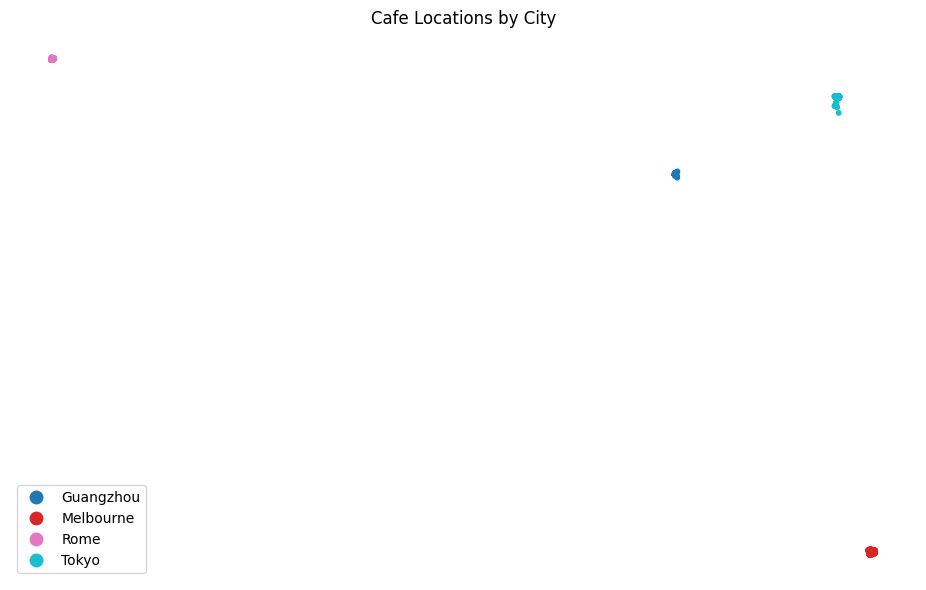

In [ ]:
# 获取当前目录下所有 *_cafes.geojson 文件
all_files = os.listdir()
cafe_files = [f for f in all_files if f.endswith('_cafes.geojson')]

# 初始化存储结构
cafe_counts = {}
gdfs = []

# 读取每个文件，记录城市名和数量
for file in cafe_files:
    try:
        city = file.split('_')[0].title()
        gdf = gpd.read_file(file)
        gdf["city"] = city
        cafe_counts[city] = len(gdf)
        gdfs.append(gdf)
    except Exception as e:
        print(f"读取 {file} 时出错：{e}")

# 打印统计结果
print("☕ 每个城市的咖啡厅数量：")
for city, count in cafe_counts.items():
    print(f"{city}: {count} cafes")

In [23]:
# 读取行政区边界（multi-polygon）
admin_path = "guangzhou_districts_bilingual.geojson"
guangzhou_admin = gpd.read_file(admin_path)
guangzhou_union = guangzhou_admin.unary_union  # 合并成一个大 Polygon

# 设置查询标签
tags = {
    "amenity": ["cafe", "restaurant"],
    "shop": ["coffee"],
    "cuisine": ["coffee_shop"]
}

# 使用 osmnx 查询符合条件的 POI
pois = ox.features_from_polygon(guangzhou_union, tags)

# 筛选出名称中包含 coffee 或 咖啡 的记录
name_mask = pois["name"].astype(str).str.contains("coffee|咖啡", case=False, na=False)
pois_filtered = pois[name_mask | pois.index.isin(pois.index)]

# 重置并清洗字段
pois_filtered = pois_filtered.reset_index()
pois_filtered["city"] = "Guangzhou"

# 可选：只保留点类型
pois_filtered = pois_filtered[pois_filtered.geometry.type == "Point"]

# 导出结果
output_path = "guangzhou_cafes_extended.geojson"
pois_filtered.to_file(output_path, driver="GeoJSON")

# 打印统计
print(f"📍 扩展标签+名称关键词后，广州咖啡相关POI数量：{len(pois_filtered)}")

📍 扩展标签+名称关键词后，广州咖啡相关POI数量：987


# get boundary

## osm获取

In [17]:
# 设置不显示下载时的警告
ox.settings.log_console = True
ox.settings.use_cache = True

# 城市名称（OSM 能识别的格式）
cities = {
    "guangzhou": "Guangzhou, China",
    "melbourne": "Melbourne, Australia",
    "rome": "Rome, Italy",
    "tokyo": "Tokyo, Japan"
}

for city_key, query in cities.items():
    print(f"正在获取 {query} 的数据...")

    # 1. 获取城市边界
    boundary = ox.geocode_to_gdf(query)
    boundary.to_file(f"{city_key}_boundary.geojson", driver="GeoJSON")

    # 2. 获取城市内的行政区（如区/郊区）
    admin = ox.geometries_from_place(query, tags={
        "boundary": "administrative",
        "admin_level": True
    })

    # 可选过滤（保留 admin_level 6–10）
    admin = admin[admin["admin_level"].isin(["6", "7", "8", "9", "10"])]
    admin = admin.to_crs(epsg=4326)
    admin.to_file(f"{city_key}_admin.geojson", driver="GeoJSON")

    print(f"✅ {city_key} 完成：边界 {len(boundary)}, 区划 {len(admin)}\n")

正在获取 Guangzhou, China 的数据...


C:\Users\10851\AppData\Local\Temp\ipykernel_25216\2913309053.py:21: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  admin = ox.geometries_from_place(query, tags={


✅ guangzhou 完成：边界 1, 区划 921

正在获取 Melbourne, Australia 的数据...


C:\Users\10851\AppData\Local\Temp\ipykernel_25216\2913309053.py:21: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  admin = ox.geometries_from_place(query, tags={


✅ melbourne 完成：边界 1, 区划 616

正在获取 Rome, Italy 的数据...


C:\Users\10851\AppData\Local\Temp\ipykernel_25216\2913309053.py:21: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  admin = ox.geometries_from_place(query, tags={


✅ rome 完成：边界 1, 区划 292

正在获取 Tokyo, Japan 的数据...


C:\Users\10851\AppData\Local\Temp\ipykernel_25216\2913309053.py:21: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  admin = ox.geometries_from_place(query, tags={


✅ tokyo 完成：边界 1, 区划 13570



## 清理行政区数据

### 广州

In [6]:
# 广州市11个行政区（市政府官网/官方地图一致）
valid_district_guangzhou = [
    "越秀区", "荔湾区", "海珠区", "天河区", "白云区",
    "黄埔区", "番禺区", "花都区", "南沙区", "从化区", "增城区"
]

In [7]:
# 设置文件路径
city = "guangzhou"
admin_path = f"{city}_admin.geojson"

# 读取完整行政边界
admin = gpd.read_file(admin_path)
admin["admin_level"] = admin["admin_level"].astype(str)

# 筛选 admin_level = "6"
districts = admin[admin["admin_level"] == "6"].copy()

# 使用官方定义的广州市行政区名称进行进一步筛选
valid_district_guangzhou = [
    "越秀区", "荔湾区", "海珠区", "天河区", "白云区",
    "黄埔区", "番禺区", "花都区", "南沙区", "从化区", "增城区"
]

districts = districts[districts["name"].isin(valid_district_guangzhou)].copy()

# 清理字段，只保留主要信息
keep_cols = ["name", "geometry", "admin_level"]
districts = districts[[col for col in keep_cols if col in districts.columns]]
districts = districts.sort_values("name")

# 保存最终清洗后的 GeoJSON
output_path = f"{city}_districts_clean.geojson"
districts.to_file(output_path, driver="GeoJSON")

print(f"✅ 广州行政区清洗完成：{output_path}，共 {len(districts)} 个市辖区")

✅ 广州行政区清洗完成：guangzhou_districts_clean.geojson，共 11 个市辖区


C:\Users\10851\AppData\Local\Temp\ipykernel_23472\1821059994.py:19: UserWarning: Glyph 20174 (\N{CJK UNIFIED IDEOGRAPH-4ECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\1821059994.py:19: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\1821059994.py:19: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\1821059994.py:19: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\1821059994.py:19: UserWarning: Glyph 27801 (\N{CJK UNIFIED IDEOGRAPH-6C99}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\1821059994.py:19: UserWarning: Glyph 22686 (\

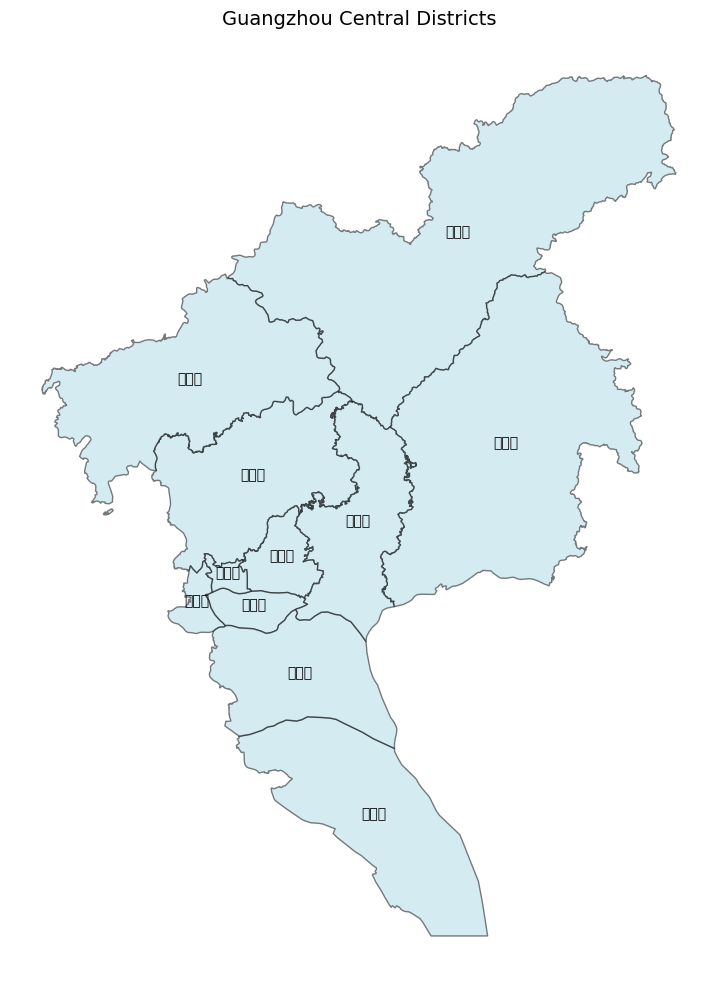

In [7]:
# 读取清洗后的广州市行政区 GeoJSON
gdf = gpd.read_file("guangzhou_districts_clean.geojson")

# 设置投影
gdf = gdf.to_crs(epsg=4326)

# 可视化
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor="black", facecolor="lightblue", alpha=0.5)

# 添加行政区名称标注
for idx, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["name"], fontsize=10, ha="center")

# 设定标题与边框
ax.set_title("Guangzhou Central Districts", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

e:\study\CASAterm2\CASA0003\groupwork\coffeestory\.venv\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\4141624831.py:34: UserWarning: Glyph 24191 (\N{CJK UNIFIED IDEOGRAPH-5E7F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\4141624831.py:34: UserWarning: Glyph 24030 (\N{CJK UNIFIED IDEOGRAPH-5DDE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\4141624831.py:34: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\4141624831.py:34: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\4141624831.py:34: UserWarning: Glyph 24

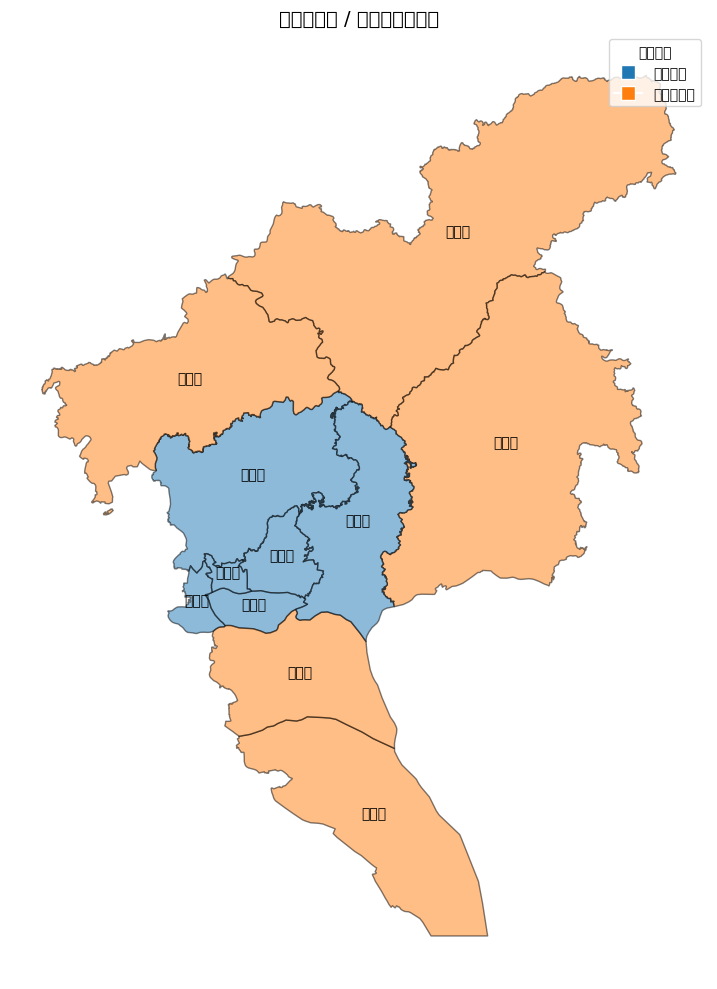

In [8]:
# 读取清洗后的行政区边界
gdf = gpd.read_file("guangzhou_districts_clean.geojson")
gdf = gdf.to_crs(epsg=4326)

# 中心城区列表
central_districts = ["越秀区", "荔湾区", "海珠区", "天河区", "白云区", "黄埔区"]

# 添加分类字段
gdf["region_type"] = gdf["name"].apply(
    lambda x: "中心城区" if x in central_districts else "非中心城区"
)

# ✅ 保存供网页可视化使用
gdf.to_file("guangzhou_districts_with_type.geojson", driver="GeoJSON")

# ✅ 可视化检查
fig, ax = plt.subplots(figsize=(10, 10))

colors = {"中心城区": "#1f77b4", "非中心城区": "#ff7f0e"}  # 蓝/橙
gdf.plot(ax=ax, column="region_type", color=gdf["region_type"].map(colors), edgecolor="black", alpha=0.5)

# 标注名称
for _, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["name"], fontsize=10, ha="center")

# 图例与标题
handles = [plt.Line2D([0], [0], marker='s', color='w', label=label,
                      markerfacecolor=color, markersize=10)
           for label, color in colors.items()]
ax.legend(handles=handles, title="区域类型")
ax.set_title("广州市中心 / 非中心城区分类", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In [10]:
# 中文 → 英文映射表
district_translation = {
    "越秀区": "Yuexiu",
    "荔湾区": "Liwan",
    "海珠区": "Haizhu",
    "天河区": "Tianhe",
    "白云区": "Baiyun",
    "黄埔区": "Huangpu",
    "番禺区": "Panyu",
    "花都区": "Huadu",
    "南沙区": "Nansha",
    "从化区": "Conghua",
    "增城区": "Zengcheng"
}

region_type_translation = {
    "中心城区": "Central",
    "非中心城区": "Non-central"
}

# 添加英文名称列
gdf["name_en"] = gdf["name"].map(district_translation)
gdf["region_type_en"] = gdf["region_type"].map(region_type_translation)

# 仅保留必要字段
gdf_clean = gdf[["name", "name_en", "region_type_en", "geometry"]].copy()

# 保存为轻量级 GeoJSON
output_path = "guangzhou_districts_bilingual.geojson"
gdf_clean.to_file(output_path, driver="GeoJSON")

print(f"✅ 简化版 GeoJSON 已保存：{output_path}")

✅ 简化版 GeoJSON 已保存：guangzhou_districts_bilingual.geojson


### 东京

In [40]:
# 读取导出的 Tokyo GeoJSON
gdf = gpd.read_file("tokyo_admin.geojson")

# 创建字段映射（英文字段已有：ADM2_EN，中文为 ADM2_JA）
gdf = gdf.rename(columns={
    "ADM2_JA": "name",
    "ADM2_EN": "name_en"
})

# 设置“中心城区”名单（都心6区）
central_wards = ["千代田区", "中央区", "港区", "新宿区", "文京区", "渋谷区"]

# 标注区域类型
gdf["region_type"] = gdf["name"].apply(
    lambda x: "中心城区" if x in central_wards else "非中心城区"
)
gdf["region_type_en"] = gdf["region_type"].map({
    "中心城区": "Central",
    "非中心城区": "Non-central"
})

# 保留所需字段
gdf_clean = gdf[["name", "name_en", "region_type", "region_type_en", "geometry"]].copy()

# 保存为简化版 GeoJSON
output_path = "tokyo_wards_bilingual_clean.geojson"
gdf_clean.to_file(output_path, driver="GeoJSON", encoding="utf-8")

print(f"✅ 已保存：{output_path}")

✅ 已保存：tokyo_wards_bilingual_clean.geojson


e:\study\CASAterm2\CASA0003\groupwork\coffeestory\.venv\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\195384839.py:37: UserWarning: Glyph 19996 (\N{CJK UNIFIED IDEOGRAPH-4E1C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整布局
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\195384839.py:37: UserWarning: Glyph 20140 (\N{CJK UNIFIED IDEOGRAPH-4EAC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整布局
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\195384839.py:37: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整布局
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\195384839.py:37: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整布局
C:\Users\10851\AppData\Local\Temp\ipykernel_23472\195384839.py:3

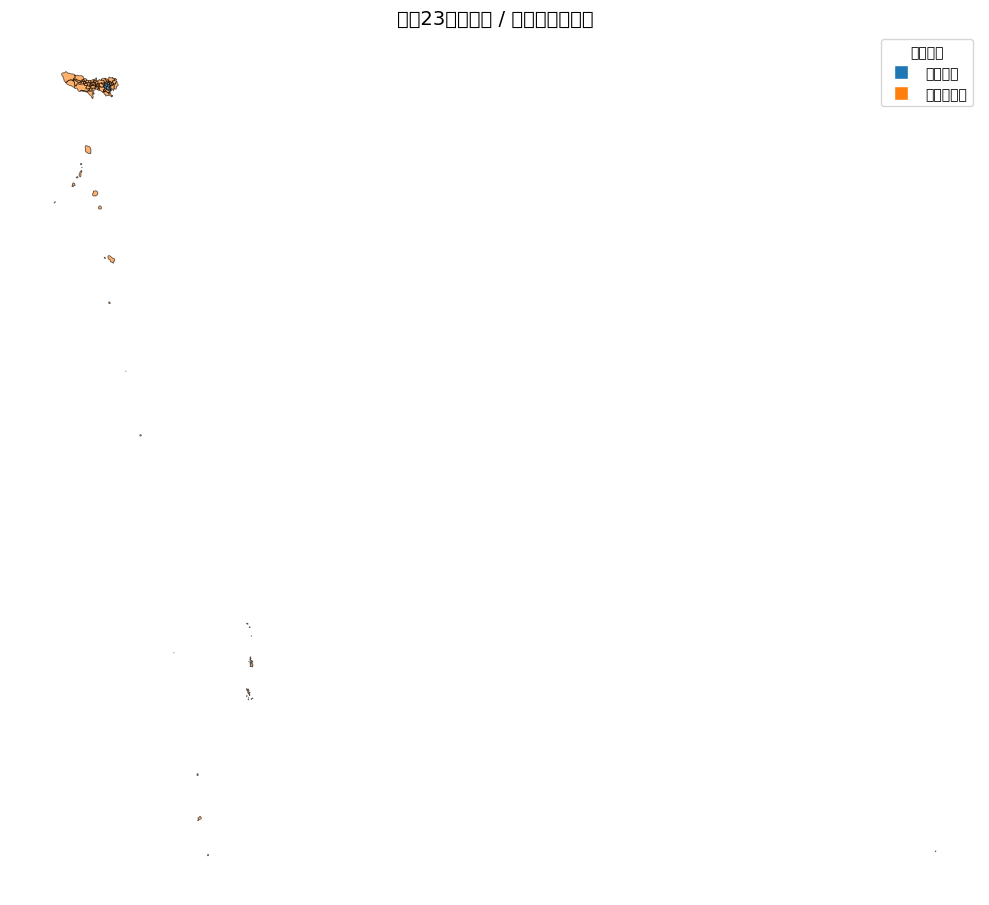

In [43]:
# 读取清理后的 Tokyo 23 区 GeoJSON
gdf = gpd.read_file("tokyo_wards_bilingual_clean.geojson")

# 设置合适的投影（适合展示）
gdf = gdf.to_crs(epsg=4326)

# 定义颜色（中心城区 / 非中心城区）
colors = {
    "中心城区": "#1f77b4",  # 蓝色
    "非中心城区": "#ff7f0e"  # 橙色
}

# 创建地图
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制边界和区域
gdf.plot(
    ax=ax,
    column="region_type",
    color=gdf["region_type"].map(colors),
    edgecolor="black",
    linewidth=0.6,
    alpha=0.6
)

# 添加图例
handles = [
    plt.Line2D([0], [0], marker='s', color='w', label=label,
               markerfacecolor=color, markersize=10)
    for label, color in colors.items()
]
ax.legend(handles=handles, title="区域类型")

# 设置标题
ax.set_title("东京23区：中心 / 非中心城区分类", fontsize=14)
ax.axis("off")  # 去掉坐标轴
plt.tight_layout()  # 自动调整布局
plt.show()

### 墨尔本